In [1]:
import os, subprocess, warnings
from datetime import datetime
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from datetime import datetime
from scipy.integrate import quad, quad_vec, trapz, cumtrapz
from scipy.optimize import fsolve
from scipy.ndimage import gaussian_filter

from sim import *
import const


In [2]:
sim_eps0p01 = Sim(ALPHA_EPS0P01, "gridded_data_small.npz")
sim_eps0p1 = Sim(ALPHA_EPS0P1, "gridded_data_small.npz")
sim_eps1p0 = Sim(ALPHA_EPS1P0, "gridded_data_small.npz")
sim_gas = Sim(GAS, "gridded_data_small.npz")
list_of_sim = [sim_eps0p01, sim_eps0p1, sim_eps1p0, sim_gas]


Moving to directory '/home/za9132/scratch/romain/alpha_eps0p01'.
Moving to directory '/home/za9132/scratch/romain/alpha_eps0p1'.
Moving to directory '/home/za9132/scratch/romain/alpha_eps1p0'.
Moving to directory '/home/za9132/scratch/romain/gas'.


In [114]:
sim = sim_eps1p0


Saved figure as 'temp-proj-z-092720231136.png'


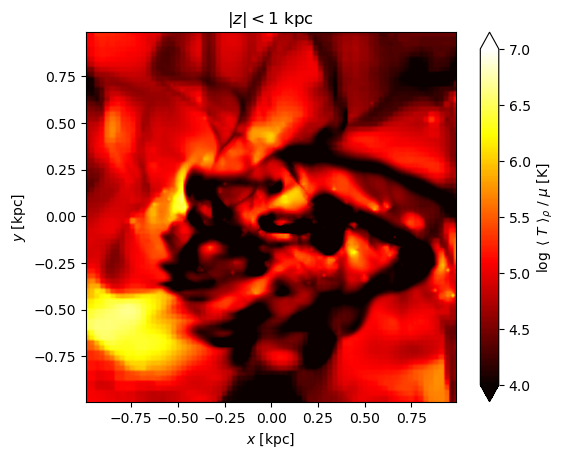

In [117]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.temperature, (1e4, 1e7), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='hot', cbar_label=r'$\log~\langle~T~\rangle_\rho~/~\mu$ [K]', cbar_tick_increment=0.5)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

sim.save_fig("temp-proj-%s" % slice_label)


Saved figure as 'metal-proj-z-092720231136.png'


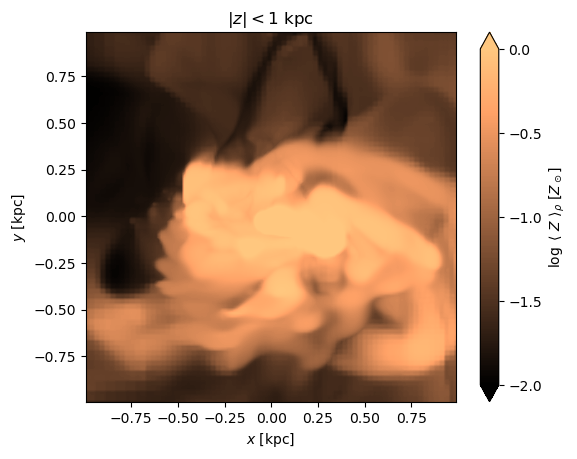

In [120]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.metallicity / const.Z_sol, (1e-2, 1e0), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='copper', cbar_label=r'$\log~\langle~Z~\rangle_\rho$ [$Z_\odot$]', cbar_tick_increment=0.5)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

sim.save_fig("metal-proj-%s" % slice_label)


Saved figure as 'density-proj-z-092720231136.png'


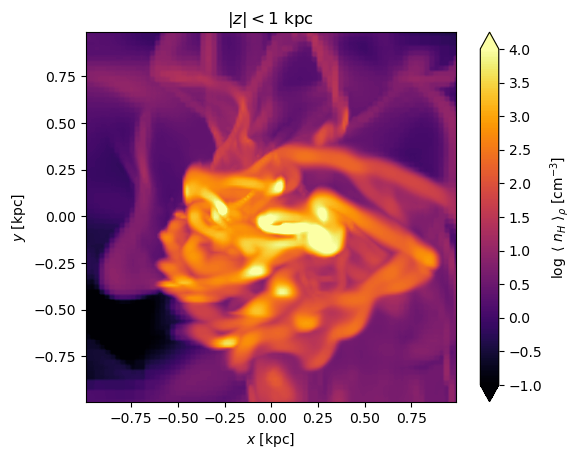

In [123]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.n_H, (1e-1, 1e4), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='inferno', cbar_label=r'$\log~\langle~n_H~\rangle_\rho$ [${\rm cm^{-3}}$]', cbar_tick_increment=0.5)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

sim.save_fig("density-proj-%s" % slice_label)


Saved figure as 'v-proj-z-092720231136.png'


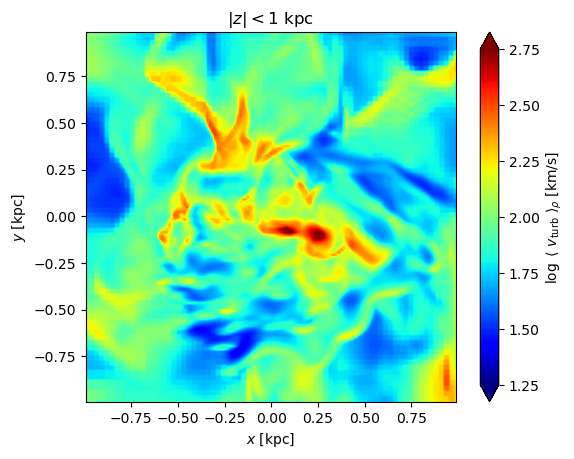

In [126]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.v_turb / (const.km), (10**(1.25), 10**(2.75)), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='jet', cbar_label=r'$\log~\langle~v_{\rm turb}~\rangle_\rho$ [km/s]', cbar_tick_increment=0.25)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

sim.save_fig("v-proj-%s" % slice_label)


Saved figure as 'mach-proj-z-092720231136.png'


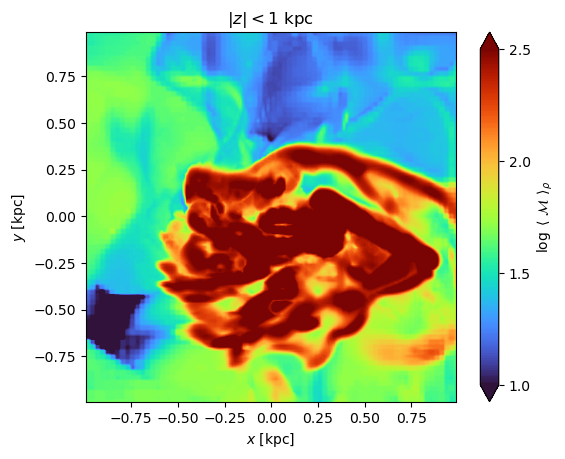

In [129]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.mach, (10**(1.), 10**(2.5)), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='turbo', cbar_label=r'$\log~\langle~\mathcal{M}~\rangle_\rho$', cbar_tick_increment=0.5)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

sim.save_fig("mach-proj-%s" % slice_label)


Saved figure as 'refine-proj-z-092720231136.png'


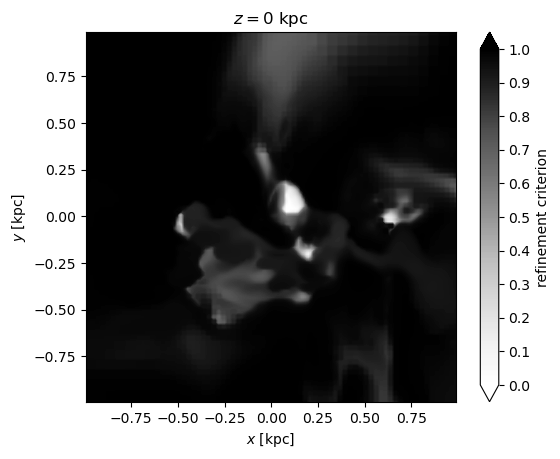

In [132]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.refinement_criterion, (0, 1), slice=slice, project=False, do_log=False, cmap='Greys', cbar_label='refinement criterion', cbar_tick_increment=0.1)

plt.title(r'$%s = 0~{\rm kpc}$' % slice_label)

sim.save_fig("refine-proj-%s" % slice_label)


In [133]:
n_H_2d, temperature_2d, mass_2d = sim.calc_phase(sim.n_H, sim.temperature, (1e-4, 1e5), (1e1, 1e9), nbins=200)


Saved figure as 'density-temp-phase-092720231137.png'


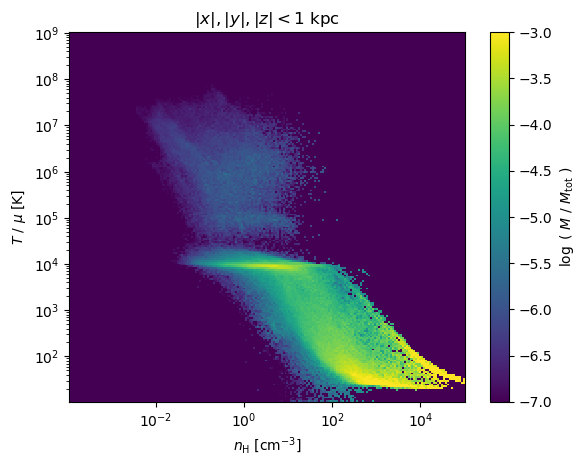

In [134]:
mass_frac_2d = mass_2d / np.sum(sim.density * sim.dV)

plt.pcolor(n_H_2d, temperature_2d, np.log10(mass_frac_2d + epsilon), vmin=-7, vmax=-3)

plt.xlabel(r"$n_{\rm H}$ [${\rm cm^{-3}}$]")
plt.ylabel(r"$T~/~\mu$ [K]")

plt.xscale('log')
plt.yscale('log')

plt.colorbar(label=r'$\log~(~M~/~M_{\rm tot}~)$')

plt.title(r'$|x|, |y|, |z| < 1~{\rm kpc}$')

sim.save_fig("density-temp-phase")


In [135]:
r_1d, density_1d = sim.calc_radial_profile(sim.density, nbins=100)


Saved figure as 'density-1d-092720231137.png'


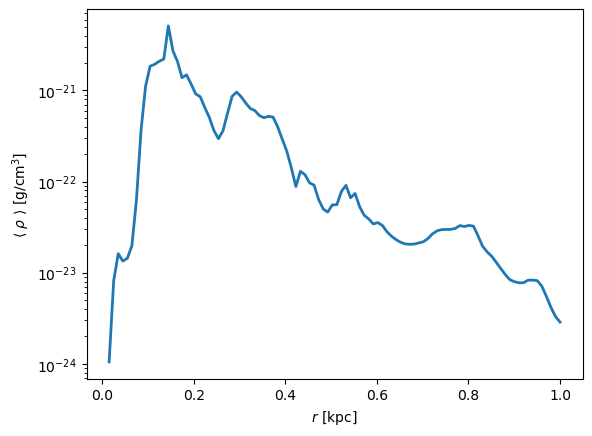

In [136]:
plt.plot(r_1d / const.kpc, density_1d, lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~\rho~\rangle$ [${\rm g/cm^3}$]')

plt.yscale('log')

sim.save_fig("density-1d")


In [137]:
r_1d, temperature_1d = sim.calc_radial_profile(sim.temperature, weight=sim.density, nbins=100)


Saved figure as 'temp-1d-092720231137.png'


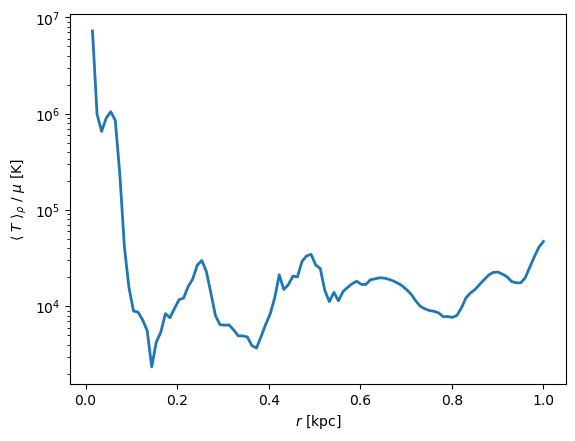

In [138]:
plt.plot(r_1d / const.kpc, temperature_1d, lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~T~\rangle_\rho~/~\mu$ [K]')

plt.yscale('log')

sim.save_fig("temp-1d")


In [139]:
r_1d, turb_energy_1d = sim.calc_radial_profile(sim.turb_energy, weight=sim.density, nbins=100)
v_turb_1d = np.sqrt(2 * turb_energy_1d)


Saved figure as 'v-turb-1d-092720231137.png'


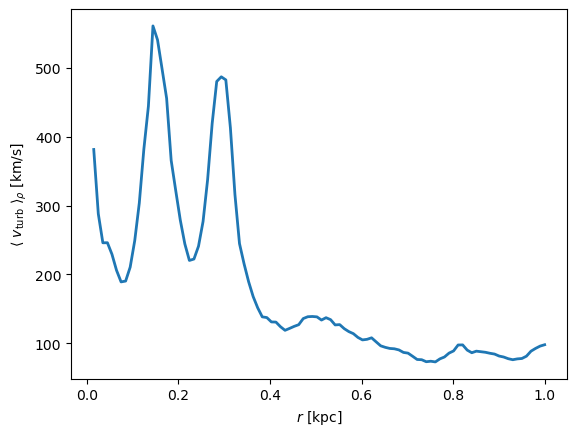

In [140]:
plt.plot(r_1d / const.kpc, v_turb_1d / (const.km), lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~v_{\rm turb}~\rangle_\rho$ [km/s]')

sim.save_fig("v-turb-1d")


In [141]:
stats = {
    'fields': [sim.density, sim.temperature, sim.metallicity / const.Z_sol, sim.v_turb / const.km, sim.mach, sim.star_age / const.Myr],
    'names': ["density", "temperature", "metallicity", "turbulent velocity", "mach number", "star age"],
    'units': ["g/cm^3", "K", "Z_sol", "km/s", "", "Myr"],
    'weights': [None, sim.density, sim.density, sim.density, sim.density, sim.star_mass],
    'types': [HYDRO, HYDRO, HYDRO, HYDRO, HYDRO, STAR]
}

sim.calc_summary_stats(**stats, do_print=True)



Field                            Max        Min          Mean  Unit
-----------------------  -----------  ---------  ------------  ------
density                     1.13e-18   1.78e-28       3.7e-23  g/cm^3
temperature                 3.98e+08  10.1        11700        K
metallicity                 8.72       0.0055         1        Z_sol
turbulent velocity       3210         11.5          234        km/s
mach number              1690          0.00525      512
star age                  297          0.802         60.2      Myr
star part number            0          0         116000
dark matter part number     0          0         300000
contamination frac          0          0              0


Saved figure as 'density-compare-092720231131.png'


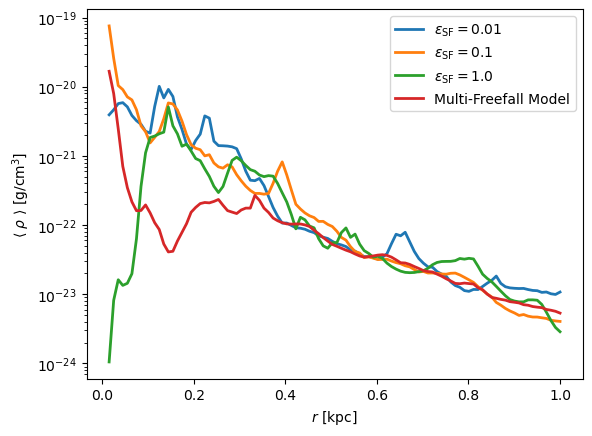

In [54]:
for sim in list_of_sim:
    
    r_1d, density_1d = sim.calc_radial_profile(sim.density, nbins=100)

    plt.plot(r_1d / const.kpc, density_1d, lw=2, label=sim.sim_latex)
    
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~\rho~\rangle$ [${\rm g/cm^3}$]')

plt.legend()

plt.yscale('log')

save_fig('density-compare')


Saved figure as 'v-turb-compare-092720231130.png'


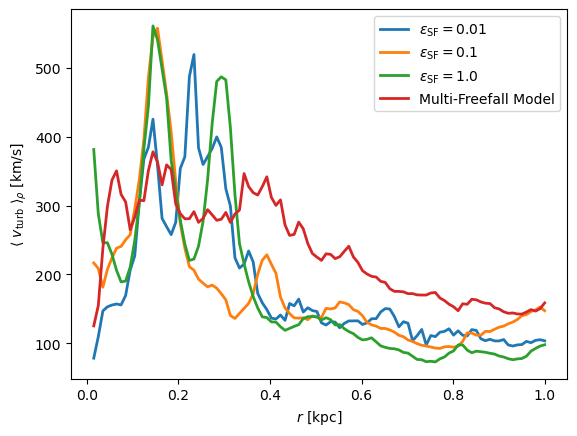

In [53]:
for sim in list_of_sim:
    
    r_1d, turb_energy_1d = sim.calc_radial_profile(sim.turb_energy, weight=sim.density, nbins=100)
    v_turb_1d = np.sqrt(2 * turb_energy_1d)

    plt.plot(r_1d / const.kpc, v_turb_1d / (const.km), lw=2, label=sim.sim_latex)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~v_{\rm turb}~\rangle_\rho$ [km/s]')

plt.legend()

save_fig('v-turb-compare')


Saved figure as 'temp-compare-092720231130.png'


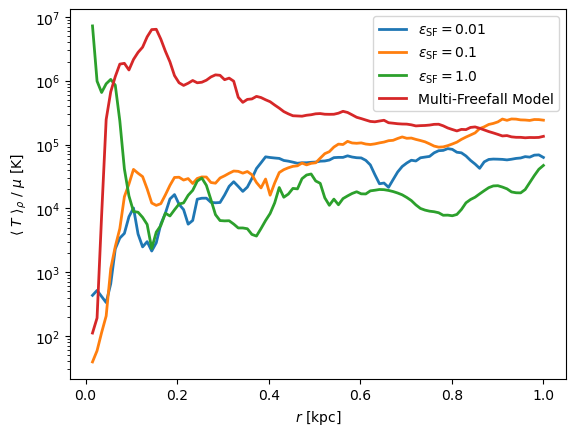

In [52]:
for sim in list_of_sim:
    
    r_1d, temperature_1d = sim.calc_radial_profile(sim.temperature, weight=sim.density, nbins=100)

    plt.plot(r_1d / const.kpc, temperature_1d, lw=2, label=sim.sim_latex)
    
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~T~\rangle_\rho~/~\mu$ [K]')

plt.legend()

plt.yscale('log')

save_fig('temp-compare')


Saved figure as 'SFR-compare-092720231119.png'


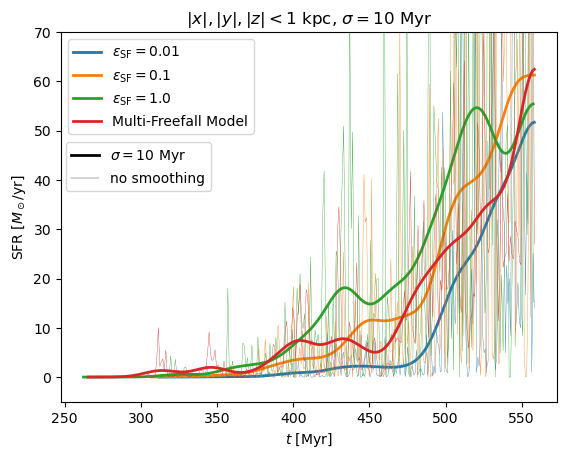

In [7]:
nbins = 300
filter_sigma = 10 * const.Myr

for i, sim in enumerate(list_of_sim):

    counts, bins = np.histogram(sim.star_birth_time, bins=nbins, weights=sim.star_mass)

    star_birth_time_1d = bins[:-1] + np.diff(bins)[0]
    star_mass_1d = counts
    SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

    filter_sigma_idx = filter_sigma / np.diff(star_birth_time_1d)[0]
    SFR_mass_1d_smoothed = gaussian_filter(SFR_mass_1d, sigma=filter_sigma_idx)
    
    plt.plot(star_birth_time_1d / const.Myr, SFR_mass_1d / const.M_sol * const.yr, lw=0.25, alpha=1., color='C%d' % i)
    plt.plot(star_birth_time_1d / const.Myr, SFR_mass_1d_smoothed / const.M_sol * const.yr, lw=2, label=sim.sim_latex, color='C%d' % i)

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

legend1 = plt.legend()
custom_lines = [Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=0.25)]
legend2 = plt.legend(custom_lines, [r'$\sigma=10~{\rm Myr}$', 'no smoothing'], loc=[0.01, 0.57])
plt.gca().add_artist(legend1)

plt.ylim(-5, 70)

plt.title(r'$|x|, |y|, |z| < 1~{\rm kpc}$, $\sigma = 10~{\rm Myr}$')

save_fig('SFR-compare')
